# NAIVE BAYES WITH SMS SPAM COLLECTION DATASET: A TEXT MINING CASE

To develop the Naive Bayes classifier, we will use data adapted from the SMS Spam
Collection at http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/.

This dataset includes the text of SMS messages along with a label indicating
whether the message is unwanted. Junk messages are labeled spam, while
legitimate messages are labeled ham. 

If you want to continue from a previously saved session state:

In [1]:
sessionfile <- "02_naive_bayes_01.RData"

if(file.exists(sessionfile)) load(sessionfile)

Load the necessary libraries:

In [2]:
library(data.table) # to handle the data in a more convenient manner
library(tidyverse) # for a better work flow and more tools to wrangle and visualize the data
library(tm) # for text mining
library(SnowballC) # for word stemming
library(gridExtra) # for multiple plots
library(wordcloud) # visualize text data
library(RColorBrewer) # for beautifying visualizations with custom colors
library(e1071) # for naive bayes
library(gmodels) # model evaluation
library(knitr) # for better table printing
library(kableExtra) # for better table printing
library(scales) # for formatting numbers
library(magrittr) # tools for better handling data structures
library(purrr) # tools for better handling data structures
library(IRdisplay) # printing html tables from kable
options(warn = -1) # for suppressing messages

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()
Loading required package: NLP

Attaching package: ‘NLP’

The following object is masked from ‘package:ggplot2’:

    annotate


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: RColorBrewer

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

 

# Data preparation

First let's read the data into a data.table object:

In [3]:
sms_raw <- fread("../data/csv/02_01_sms_spam.csv")

Review the data:

In [4]:
head(sms_raw)

type,text
ham,Hope you are having a good week. Just checking in
ham,K..give back my thanks.
ham,Am also doing in cbe only. But have to pay.
spam,"complimentary 4 STAR Ibiza Holiday or £10,000 cash needs your URGENT collection. 09066364349 NOW from Landline not to lose out! Box434SK38WP150PPM18+"
spam,okmail: Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm
ham,Aiya we discuss later lar... Pick u up at 4 is it?


Let's sample 10 ham and 10 spam entries:

In [5]:
set.seed(2018)
sample1 <- data.table(ham = sms_raw[type == "ham"][sample(.N, 10), text],
           spam = sms_raw[type == "spam"][sample(.N, 10), text])



In [6]:
sample1

ham,spam
"Hi, wkend ok but journey terrible. Wk not good as have huge back log of marking to do",Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed £1000 cash or £5000 prize!
Designation is software developer and may be she get chennai:),Are you unique enough? Find out from 30th August. www.areyouunique.co.uk
Yo im right by yo work,For the most sparkling shopping breaks from 45 per person; call 0121 2025050 or visit www.shortbreaks.org.uk
"Sorry, I can't text & drive coherently, see you in twenty","WELL DONE! Your 4* Costa Del Sol Holiday or £5000 await collection. Call 09050090044 Now toClaim. SAE, TCs, POBox334, Stockport, SK38xh, Cost£1.50/pm, Max10mins"
Is ur lecture over?,U have a secret admirer. REVEAL who thinks U R So special. Call 09065174042. To opt out Reply REVEAL STOP. 1.50 per msg recd. Cust care 07821230901
I'm stuck in da middle of da row on da right hand side of da lt...,"44 7732584351, Do you want a New Nokia 3510i colour phone DeliveredTomorrow? With 300 free minutes to any mobile + 100 free texts + Free Camcorder reply or call 08000930705."
EY! CALM DOWNON THEACUSATIONS.. ITXT U COS IWANA KNOW WOTU R DOIN AT THEW/END... HAVENTCN U IN AGES..RING ME IF UR UP4 NETHING SAT.LOVE J XXX.,Please CALL 08712402902 immediately as there is an urgent message waiting for you.
"K, jason says he's gonna be around so I'll be up there around #","Congratulations! Thanks to a good friend U have WON the £2,000 Xmas prize. 2 claim is easy, just call 08718726978 NOW! Only 10p per minute. BT-national-rate"
No need to buy lunch for me.. I eat maggi mee..,You have won a guaranteed 32000 award or maybe even £1000 cash to claim ur award call free on 0800 ..... (18+). Its a legitimat efreefone number wat do u think???
Can you pls send me that company name. In saibaba colany,URGENT! We are trying to contact U. Todays draw shows that you have won a £800 prize GUARANTEED. Call 09050003091 from land line. Claim C52. Valid 12hrs only


"free" and "urgent" words appear in spams while not in hams

View the structure of the object:

In [7]:
str(sms_raw)

Classes ‘data.table’ and 'data.frame':	5559 obs. of  2 variables:
 $ type: chr  "ham" "ham" "ham" "spam" ...
 $ text: chr  "Hope you are having a good week. Just checking in" "K..give back my thanks." "Am also doing in cbe only. But have to pay." "complimentary 4 STAR Ibiza Holiday or £10,000 cash needs your URGENT collection. 09066364349 NOW from Landline "| __truncated__ ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "index")= int 
  ..- attr(*, "__type")= int  1 2 3 6 7 8 10 11 12 13 ...


It is better that we convert "type" from character to factor: 

In [8]:
sms_raw[,type := as.factor(type)]

In [9]:
str(sms_raw)

Classes ‘data.table’ and 'data.frame':	5559 obs. of  2 variables:
 $ type: Factor w/ 2 levels "ham","spam": 1 1 1 2 2 1 1 1 2 1 ...
 $ text: chr  "Hope you are having a good week. Just checking in" "K..give back my thanks." "Am also doing in cbe only. But have to pay." "complimentary 4 STAR Ibiza Holiday or £10,000 cash needs your URGENT collection. 09066364349 NOW from Landline "| __truncated__ ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "index")= int 


## Clean and Standardize Text Data

SMS messages are strings of text composed of words, spaces, numbers, and
punctuation.

Handling this type of complex data takes a lot of thought and
effort.

One needs to consider how to remove numbers and punctuation; handle
uninteresting words such as and, but, and or; and how to break apart sentences into
individual words.

The first step in processing text data involves creating a corpus, which is a collection of text documents.

The documents can be short or long, from individual news articles, pages in a book or on the web, or entire books.

In our case, the corpus will be a collection of SMS messages.

In [10]:
# read text with VectorSource and create corpus with VCorpus

sms_corpus <- sms_raw[,tm::VectorSource(text)] %>% tm::VCorpus()

Corpus holds documents for each of the messages:

In [11]:
sms_corpus

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 5559

We can get a summary of specific messages with tm::inspect() function

In [12]:
tm::inspect(sms_corpus[1:2])

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 2

[[1]]
<<PlainTextDocument>>
Metadata:  7
Content:  chars: 49

[[2]]
<<PlainTextDocument>>
Metadata:  7
Content:  chars: 23



To get the actual message, we should convert a list item to character:

In [13]:
as.character(sms_corpus[[1]])

[1] "Hope you are having a good week. Just checking in"

For viewing multiple messages, we'll use sapply:

In [14]:
sapply(sms_corpus[1:2], as.character)

1 
"Hope you are having a good week. Just checking in" 
                                                  2 
                          "K..give back my thanks."

In order to perform our analysis, we need to divide these messages into individual words.

But first, we need to clean the text, in order to standardize the words, by removing punctuation and other characters that clutter the result.

For example, we would like the strings Hello!, HELLO, and hello to be counted as instances of the same word.

The tm_map() function provides a method to apply a transformation (also known as mapping) to a tm corpus.

**tm_map to a corpus object is what "lapply" to an ordinary list object is: It applies the same function to all of its items and returns a corpus object**

### Case lowering

Our first order of business will be to standardize the messages to use only lowercase
characters. 

In [15]:
sms_corpus_clean <- tm::tm_map(sms_corpus, tm::content_transformer(tolower))

Let's compare a message before and after transformation:

In [16]:
as.character(sms_corpus[[1]])
as.character(sms_corpus_clean[[1]])

[1] "Hope you are having a good week. Just checking in"

[1] "hope you are having a good week. just checking in"

### Cleaning numbers

Let's remove numbers from messages:

In [17]:
sms_corpus_clean <- tm::tm_map(sms_corpus_clean, removeNumbers)

And the result:

In [18]:
sapply(sms_corpus[4:5], as.character)
sapply(sms_corpus_clean[4:5], as.character)

4 
            "complimentary 4 STAR Ibiza Holiday or £10,000 cash needs your URGENT collection. 09066364349 NOW from Landline not to lose out! Box434SK38WP150PPM18+" 
                                                                                                                                                                  5 
"okmail: Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm"

4 
               "complimentary  star ibiza holiday or £, cash needs your urgent collection.  now from landline not to lose out! boxskwpppm+" 
                                                                                                                                          5 
"okmail: dear dave this is your final notice to collect your * tenerife holiday or # cash award! call  from landline. tcs sae box cwwx ppm"

### Clean stop words

Our next task is to remove filler words such as to, and, but, and or from our SMS
messages.

These terms are known as stop words and are typically removed prior to
text mining.

This is due to the fact that although they appear very frequently, they do
not provide much useful information for machine learning.

In [19]:
tm::stopwords()

[1] "i"          "me"         "my"         "myself"     "we"        
  [6] "our"        "ours"       "ourselves"  "you"        "your"      
 [11] "yours"      "yourself"   "yourselves" "he"         "him"       
 [16] "his"        "himself"    "she"        "her"        "hers"      
 [21] "herself"    "it"         "its"        "itself"     "they"      
 [26] "them"       "their"      "theirs"     "themselves" "what"      
 [31] "which"      "who"        "whom"       "this"       "that"      
 [36] "these"      "those"      "am"         "is"         "are"       
 [41] "was"        "were"       "be"         "been"       "being"     
 [46] "have"       "has"        "had"        "having"     "do"        
 [51] "does"       "did"        "doing"      "would"      "should"    
 [56] "could"      "ought"      "i'm"        "you're"     "he's"      
 [61] "she's"      "it's"       "we're"      "they're"    "i've"      
 [66] "you've"     "we've"      "they've"    "i'd"        "you'd"     
 [71] "he'd"       "she'd"      "we'd"       "they'd"     "i'll"      
 [76] "you'll"     "he'll"      "she'll"     "we'll"      "they'll"   
 [81] "isn't"      "aren't"     "wasn't"     "weren't"    "hasn't"    
 [86] "haven't"    "hadn't"     "doesn't"    "don't"      "didn't"    
 [91] "won't"      "wouldn't"   "shan't"     "shouldn't"  "can't"     
 [96] "cannot"     "couldn't"   "mustn't"    "let's"      "that's"    
[101] "who's"      "what's"     "here's"     "there's"    "when's"    
[106] "where's"    "why's"      "how's"      "a"          "an"        
[111] "the"        "and"        "but"        "if"         "or"        
[116] "because"    "as"         "until"      "while"      "of"        
[121] "at"         "by"         "for"        "with"       "about"     
[126] "against"    "between"    "into"       "through"    "during"    
[131] "before"     "after"      "above"      "below"      "to"        
[136] "from"       "up"         "down"       "in"         "out"       
[141] "on"         "off"        "over"       "under"      "again"     
[146] "further"    "then"       "once"       "here"       "there"     
[151] "when"       "where"      "why"        "how"        "all"       
[156] "any"        "both"       "each"       "few"        "more"      
[161] "most"       "other"      "some"       "such"       "no"        
[166] "nor"        "not"        "only"       "own"        "same"      
[171] "so"         "than"       "too"        "very"

In [20]:
sms_corpus_clean <- tm::tm_map(sms_corpus_clean, tm::removeWords, tm::stopwords())

### Remove punctuation

We can also eliminate any punctuation from
the text messages using the built-in removePunctuation() transformation:

In [21]:
sms_corpus_clean <- tm::tm_map(sms_corpus_clean, tm::removePunctuation)

We could also write a custom function to replace punctuation with whitespaces instead of removing them and then apply with tm_map:

In [22]:
replacePunctuation <- function(x)
{
    gsub("[[:punct:]]+", " ", x)
}

In [23]:
removePunctuation("Hello World")
replacePunctuation("Hello...World")
replacePunctuation("Hello... World")

[1] "Hello World"

[1] "Hello World"

[1] "Hello  World"

### Word stemming

Another common standardization for text data involves reducing words to their root form in a process called stemming.

The stemming process takes words like learned,learning, and learns, and strips the suffix in order to transform them into the base
form, learn. 

This allows machine learning algorithms to treat the related terms as a single concept rather than attempting to learn a pattern for each variant.

Let's see an example on how it works:

In [24]:
SnowballC::wordStem(c("learn", "learned", "learning", "learns"))

[1] "learn" "learn" "learn" "learn"

We "apply" this function to a corpus through the tm function tm::stemDocument

In [25]:
sms_corpus_clean <- tm::tm_map(sms_corpus_clean, tm::stemDocument)

And let's see the results:

In [26]:
set.seed = 1500
samplerows <- sample(1:length(sms_corpus), 10)
data.frame(type = sms_raw[samplerows, type],
           original = sapply(sms_corpus[samplerows], as.character),
          cleaned = sapply(sms_corpus_clean[samplerows], as.character))

,type,original,cleaned
1446,ham,My sister going to earn more than me da.,sister go earn da
3159,ham,Yes baby! We can study all the positions of the kama sutra ;),yes babi can studi posit kama sutra
842,ham,Nope. I just forgot. Will show next week,nope just forgot will show next week
528,ham,"Sorry, I'll call later",sorri call later
4233,ham,"I sent you the prices and do you mean the # g,",sent price mean g
2977,ham,Idea will soon get converted to live:),idea will soon get convert live
1821,ham,"Its ok, called mom instead have fun",ok call mom instead fun
5133,ham,"Piggy, r u awake? I bet u're still sleeping. I'm going 4 lunch now...",piggi r u awak bet ure still sleep go lunch now
3322,ham,"Oh right, ok. I'll make sure that i do loads of work during the day! got a really nasty cough today and is dry n shot so that should really help it!",oh right ok make sure load work day got realli nasti cough today dri n shot realli help
359,spam,"You can stop further club tones by replying STOP MIX See my-tone.com/enjoy. html for terms. Club tones cost GBP4.50/week. MFL, PO Box 1146 MK45 2WT (2/3)",can stop club tone repli stop mix see tonecomenjoy html term club tone cost gbpweek mfl po box mk wt


### Strip whitespaces

Now we should strip additional whitespaces

In [27]:
tm::stripWhitespace("a       a")

[1] "a a"

In [28]:
sms_corpus_clean <- tm::tm_map(sms_corpus_clean, tm::stripWhitespace)

### Split documents into words 

Now that the data are processed to our liking, the final step is to split the messages
into individual components through a process called tokenization.

A token is a single element of a text string; in this case, the tokens are words.

We have two options two have an object for this:

- a data structure called a Document Term Matrix (DTM) in which rows indicate documents (SMS messages) and columns indicate terms (words).

- a data structure for a Term Document Matrix (TDM), which is simply a transposed DTM in which the rows are terms and the columns are documents.


Why the need for both?

Sometimes, it is more convenient to work with one or the other.

- For example, if the number of documents is small, while the word list is large, it may make sense to use a TDM because it is generally easier to display many rows than to display many columns.
- This said, the two are often interchangeable.

Let's create the DocumentTermMatrix:

In [29]:
sms_dtm <- tm::DocumentTermMatrix(sms_corpus_clean)

Let's see the structure and an excerpt of the matrix:

In [30]:
str(sms_dtm)

List of 6
 $ i       : int [1:42147] 1 1 1 1 1 2 2 2 3 3 ...
 $ j       : int [1:42147] 967 2282 2581 2938 6210 436 2990 5628 200 916 ...
 $ v       : num [1:42147] 1 1 1 1 1 1 1 1 1 1 ...
 $ nrow    : int 5559
 $ ncol    : int 6559
 $ dimnames:List of 2
  ..$ Docs : chr [1:5559] "1" "2" "3" "4" ...
  ..$ Terms: chr [1:6559] "‘morrow" "‘rent" "’llspeak" "’re" ...
 - attr(*, "class")= chr [1:2] "DocumentTermMatrix" "simple_triplet_matrix"
 - attr(*, "weighting")= chr [1:2] "term frequency" "tf"


We should interpret above object as follows:

- There are a total of 5559 documents and 6559 terms
- Although there are 3.6e7 possible doc-term matches (5559 * 6559), each document contains only a handful of terms. Total number of doc-term matches are 42147 (where a document has at least one instance of a term)
- "i" object shows the index of the docs in 42K matches
- "j" object shows the index of the terms in 42K matches
- "v" object shows the count of the appearance of the term in the match

- First document has one instances of 967., 2282., 2581. 2938. and 6210. terms each

Let's check:

Let's play with the 1st document:

In [31]:
doci <- 1
doci

[1] 1

First let's view the first document: 

In [32]:
sapply(sms_corpus_clean[doci], as.character)

1 
"hope good week just check"

Term matches of the 1st document occurs in the dtm at:

In [33]:
# get the indices in dtm where matches of 1st document occurs 
dtm_indices_1 <- which(sms_dtm$i == doci)
dtm_indices_1

[1] 1 2 3 4 5

Get the term indices of those matches:

In [34]:
term_indices <- sms_dtm$j[dtm_indices_1]
term_indices

[1]  967 2282 2581 2938 6210

See those terms:

In [35]:
sms_dtm$dimnames$Terms[term_indices]

[1] "check" "good"  "hope"  "just"  "week"

Just the sorted and unique versions of the terms of the 1st document

Now, v shows the count of occurences of the term inside the doc. Let's possible values in this corpus:

In [36]:
unique_vs <- unique(sms_dtm$v)
unique_vs

[1]  1  2  3  4 11  5  6 10  7 15

So there is at least one instance in which a term appears 15 times in a doc. Let's get that:

First let's find the indices of 15 occurences:

In [37]:
index_at_max_v <- which(sms_dtm$v == max(unique_vs))
index_at_max_v

[1] 38432

See which term it is:

In [38]:
term_ind_at_max_v <- sms_dtm$j[index_at_max_v]
term_ind_at_max_v

sms_dtm$dimnames$Terms[term_ind_at_max_v]

[1] 2433

[1] "happi"

And see which doc it is:

In [39]:
doc_ind_at_max_v <- sms_dtm$i[index_at_max_v]
doc_ind_at_max_v

sapply(sms_corpus_clean[doc_ind_at_max_v], as.character)

[1] 5068

5068 
"fast approach wish u happi new year happi sankranti happi republ day happi valentin day happi shivratri happi ugadi happi fool day happi may day happi independ day happi friendshipmotherfatherteacherschildren day happi birthday u happi ganesh festiv happi dasara happi diwali happi christma good morn afternoon even night rememberi first wish u s raj"

We can also index the dtm as a matrix and view the contents with inspect

In [40]:
inspect(sms_dtm[doc_ind_at_max_v, term_ind_at_max_v])

<<DocumentTermMatrix (documents: 1, terms: 1)>>
Non-/sparse entries: 1/0
Sparsity           : 0%
Maximal term length: 5
Weighting          : term frequency (tf)
Sample             :
      Terms
Docs   happi
  5068    15


Let's get 10 random matches (docs + terms) and subset the dtm for them:

In [41]:
set.seed(2000)
sample2 <- sample(length(sms_dtm[[1]]), 10)

docs <- sms_dtm[[1]][sample2]
terms <- sms_dtm[[2]][sample2]

sample_mat <- tm::inspect(sms_dtm[docs, terms])

<<DocumentTermMatrix (documents: 10, terms: 10)>>
Non-/sparse entries: 12/88
Sparsity           : 88%
Maximal term length: 7
Weighting          : term frequency (tf)
Sample             :
      Terms
Docs   can dear entri kind maxim secret stop whisper wick wish
  1084   0    0     0    0     0      0    0       0    1    0
  2040   0    0     1    0     0      0    0       0    0    0
  2181   1    0     0    0     0      0    0       1    0    0
  2392   1    0     0    0     0      0    0       0    0    0
  3429   0    0     0    0     0      1    1       0    0    0
  3989   0    0     0    0     0      0    1       0    0    0
  4042   0    0     0    0     0      0    0       0    0    1
  4510   0    1     0    0     0      0    0       0    0    0
  4541   0    0     0    1     0      0    0       0    0    0
  5330   0    0     0    0     1      0    0       0    0    0


However, it would be better to view them together with the doc contents:

In [42]:
data.table(docs = sapply(sms_corpus_clean[docs], as.character), sample_mat)

docs,can,dear,entri,kind,maxim,secret,stop,whisper,wick,wish
mmmm fair know weak grin push knee expos belli pull head forget know wick smile,0,0,0,0,0,0,0,0,1,0
u wait bus stop aft ur lect lar dun c u go get car come back n pick u,0,0,1,0,0,0,0,0,0,0
free entri £ week comp just send word enter now tc wwwtextcompcom cust care,1,0,0,0,0,0,0,1,0,0
mmmmmmm snuggl deep content sigh whisper love much can bare stand,1,0,0,0,0,0,0,0,0,0
today accept dayu accept brother sister lover dear best clos lvblefrnd jstfrnd cutefrnd lifpartnr belovd swtheart bstfrnd rpli mean enemi,0,0,0,0,0,1,1,0,0,0
can see see mayb reboot ym seen buzz,0,0,0,0,0,0,1,0,0,0
ur cashbal current pound maxim ur cash now send cash pmsg cc po box tcrw,0,0,0,0,0,0,0,0,0,1
thank lot wish birthday thank make birthday truli memor,0,1,0,0,0,0,0,0,0,0
pleas sen kind advic pleas come tri,0,0,0,1,0,0,0,0,0,0
u secret admir reveal think u r special call opt repli reveal stop per msg recd cust care,0,0,0,0,1,0,0,0,0,0


We just created an sms_dtm object that contains the tokenized corpus using the default settings, which apply minimal processing.

The default settings are appropriate because we have already prepared the corpus manually.

On the other hand, if we hadn't performed the preprocessing, we could do so
here by providing a list of control parameter options to override the defaults.

For example, to create a DTM directly from the raw, unprocessed SMS corpus, we can use the following command:

In [43]:
sms_dtm2 <- DocumentTermMatrix(sms_corpus,
    control = list(
        tolower = TRUE,
        removeNumbers = TRUE,
        stopwords = TRUE,
        removePunctuation = TRUE,
        stemming = TRUE
        )
    )

In [44]:
str(sms_dtm2)

List of 6
 $ i       : int [1:43221] 1 1 1 1 1 2 2 2 3 3 ...
 $ j       : int [1:43221] 990 2348 2685 3082 6568 448 3138 5923 201 939 ...
 $ v       : num [1:43221] 1 1 1 1 1 1 1 1 1 1 ...
 $ nrow    : int 5559
 $ ncol    : int 6961
 $ dimnames:List of 2
  ..$ Docs : chr [1:5559] "1" "2" "3" "4" ...
  ..$ Terms: chr [1:6961] "‘morrow" "‘rent" "“harri" "“it" ...
 - attr(*, "class")= chr [1:2] "DocumentTermMatrix" "simple_triplet_matrix"
 - attr(*, "weighting")= chr [1:2] "term frequency" "tf"


It might have some differences with the previous dtm due to application order of cleaning steps

In [45]:
sms_tdm <- tm::TermDocumentMatrix(sms_corpus_clean)

## Split dataset into train and test sets

With a .75/.25 split, we will have 4169 train and 1390 test observations:

Remember that, sms_raw is a data.table and in a data.table, .I is a placeholder for 1:nrows(DTobject)

In [46]:
train_ind <- 1:4169
test_ind <- sms_raw[,.I[-train_ind]]

In [47]:
sms_dtm_train <- sms_dtm[train_ind,]
sms_dtm_test <- sms_dtm[test_ind,]

We should have a respective split of the type vector also:

In [48]:
sms_train_labels <- sms_raw[train_ind, type]
sms_test_labels <- sms_raw[test_ind, type]

To confirm that the subsets are representative of the complete set of SMS data, let's
compare the proportion of spam in the training and test data frames:

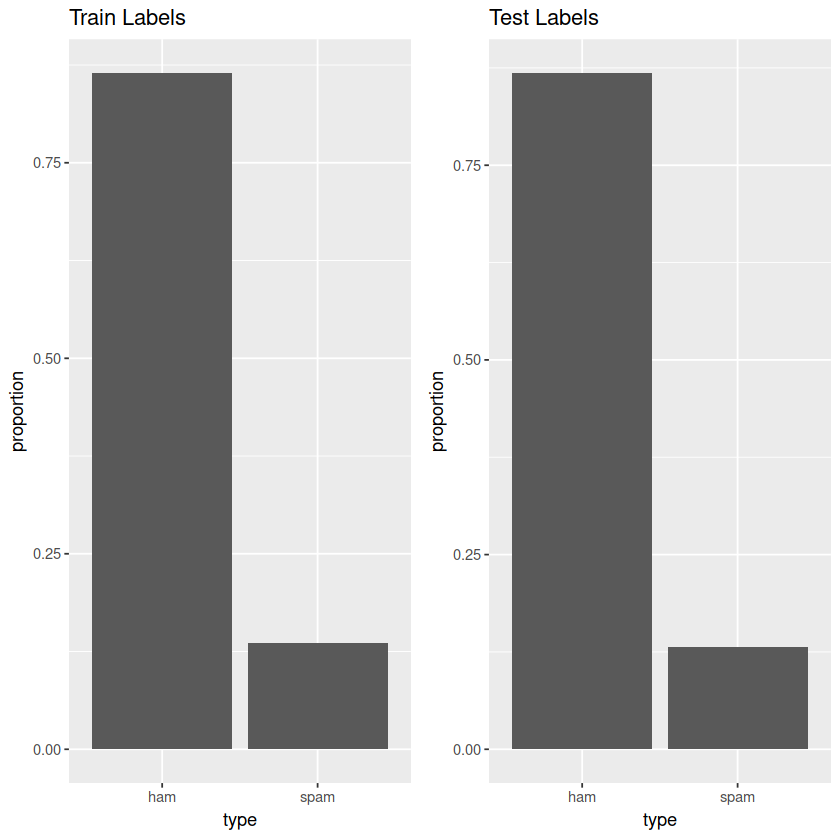

In [107]:
p1 <- ggplot2::ggplot(data.frame(labels = sms_train_labels)) +
geom_bar(aes(x = labels, y = ..count../sum(..count..)), height = 0.1) +
ggtitle("Train Labels") +
labs(x = "type", y = "proportion")

p2 <- ggplot2::ggplot(data.frame(labels = sms_test_labels)) +
geom_bar(aes(x = labels, y = ..count../sum(..count..)), height = 0.1) +
ggtitle("Test Labels") +
labs(x = "type", y = "proportion")

gridExtra::grid.arrange(p1, p2, ncol = 2)

The proportions are alike across sets.

We can also confirm this with prop tables:

Note the use of sapply against the newly created list with titles and the closure - unnamed embedded function:

In [50]:
sapply(list(Train = sms_train_labels,
            Test = sms_test_labels),
      function(x) prop.table(table(x)))

,Train,Test
ham,0.8647158,0.8683453
spam,0.1352842,0.1316547


## Visualize text data with word cloud

A word cloud is a way to visually depict the frequency at which words appear in text data.

The cloud is composed of words scattered somewhat randomly around the figure.

Words appearing more often in the text are shown in a larger font, while less common terms are shown in smaller fonts.

This type of figures grew in popularity recently, since it provides a way to observe trending topics on social media websites.

We can create a word cloud directly from the corpus, for words that appear at least 50 times.

With random.order = F, more frequent words are placed closer to the center.

We beautify the cloud with RColorBrewer package:

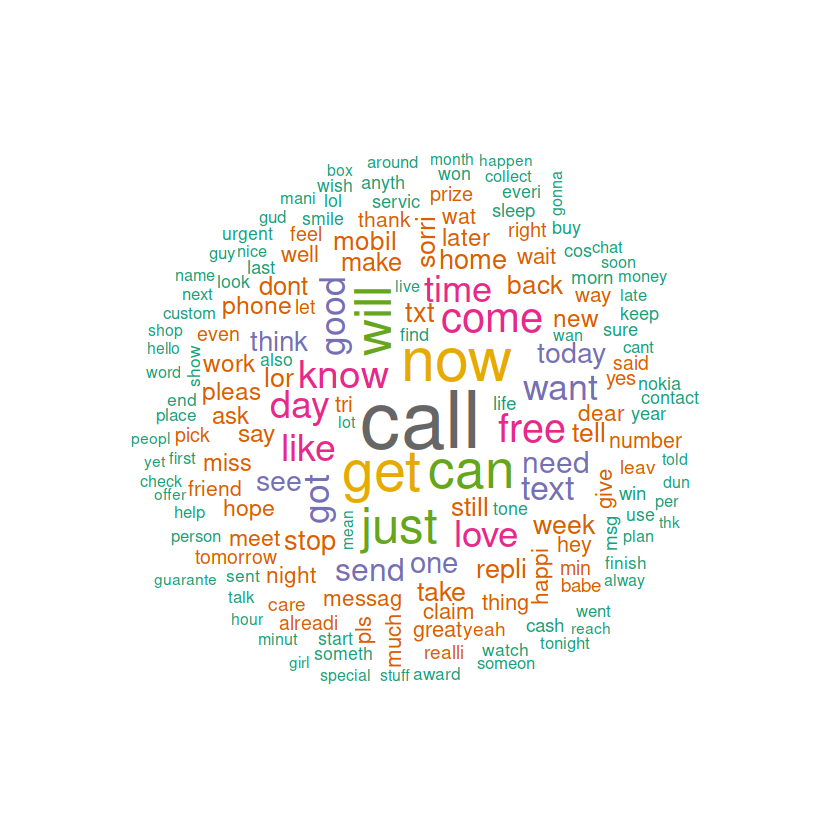

In [51]:
wordcloud::wordcloud(sms_corpus_clean,
                        min.freq = 50,
                        random.order = F,
                        colors = RColorBrewer::brewer.pal(8, "Dark2"))

We can also create separate word clouds for hams and spams directly from the raw sms object.

wordcloud automatically does the necessary transformations

We do that in the concise "data.table" way:

type


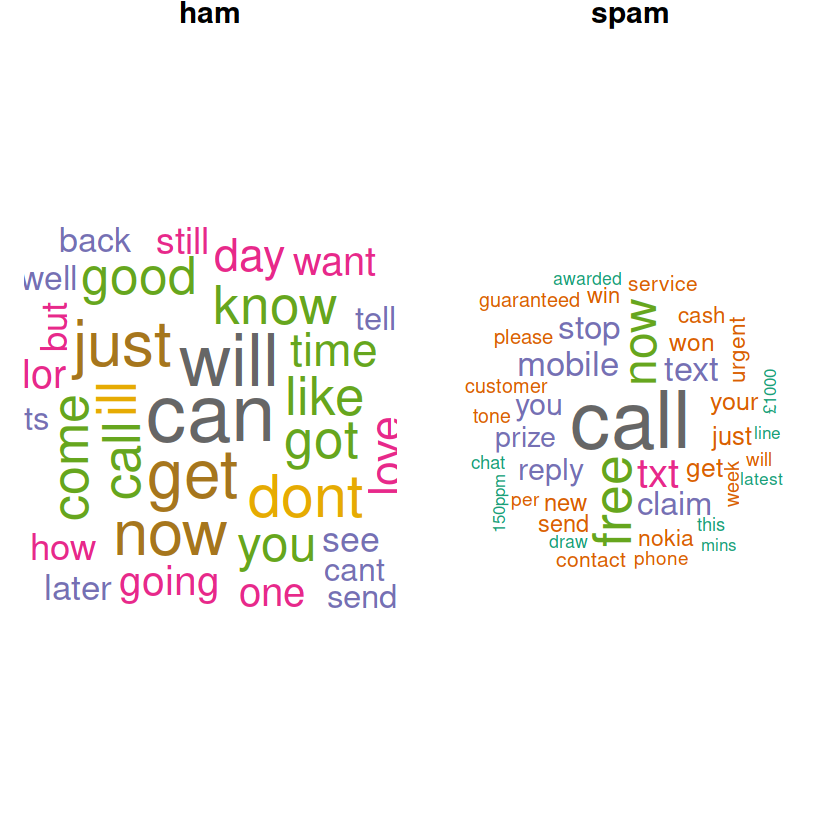

In [52]:
# open new plot
plot.new()

# set parameters for layout, margins and main title relative text size
par(mfrow=c(1,2), mar = rep(1,4), cex.main = 1.5)

# inside data.table, for each type category (ham, spam), create a wordcloud and set a main title
# note the use of curly braces "{...}" for multiple statements
# "by" clause for aggregate/split operations
sms_raw[, { wordcloud::wordcloud(text,
         max.words = 40,
         #scale = c(1, 1),
         random.order = F,
         colors = RColorBrewer::brewer.pal(8, "Dark2"))
         title(main = type) }
, by = type]

You can realize that "spam" cloud includes some words like "free", "claim", "mobile", "prize" that do not appear in the "ham" cloud

within words common to both, "call" is more frequent in "spam" while "now", "get", "just", "you" and "will" are more frequent in "ham" cloud

"can" appears in the "ham" cloud and not "spam" cloud

## Filtering for more frequent words and creating indicator features

The final step in the data preparation process is to transform the sparse matrix into a data structure that can be used to train a Naive Bayes classifier.

Currently, the sparse matrix includes over 6,500 features; this is a feature for every word that appears in at least one SMS message. It's unlikely that all of these are useful for classification.

To reduce the number of features, we will eliminate any word that appear in less than five SMS messages, or in less than about 0.1 percent of the records in the training data.

In [53]:
sms_freq_words <- tm::findFreqTerms(sms_dtm_train, 5)

In [54]:
str(sms_freq_words)

 chr [1:1139] "£wk" "€˜m" "€˜s" "abiola" "abl" "abt" "accept" "access" ...


There are 1139 words appearing in at least 5 messages

We now need to filter our DTM to include only the terms appearing in a specified
vector.

As done earlier, we'll use the data frame style [row, col] operations to
request specific portions of the DTM, noting that the columns are named after the
words the DTM contains. We can take advantage of this to limit the DTM to specific
words

In [55]:
sms_dtm_freq_train <- sms_dtm_train[ , sms_freq_words]

sms_dtm_freq_test <- sms_dtm_test[ , sms_freq_words]

In [56]:
lapply(list(train = sms_dtm_train, freq_train = sms_dtm_freq_train), dim)
lapply(list(test = sms_dtm_test, freq_test = sms_dtm_freq_test), dim)

$train
[1] 4169 6559

$freq_train
[1] 4169 1139

$test
[1] 1390 6559

$freq_test
[1] 1390 1139

Note how number of columns - denoting terms - shrank after the filtering. Row counts are preserved

The Naive Bayes classifier is typically trained on data with categorical features.

This poses a problem, since the cells in the sparse matrix are numeric and measure the number of times a word appears in a message.

We need to change this to a categorical variable that simply indicates yes or no depending on whether the word appears at all.

We first create a custom function and then apply it on the column margin of the dtm's:

In [57]:
convert_counts <- function(x)
{
    x <- ifelse(x > 0, "Yes", "No")
}

In [58]:
sms_train <- apply(sms_dtm_freq_train, MARGIN = 2, convert_counts)

sms_test <- apply(sms_dtm_freq_test, MARGIN = 2, convert_counts)


The result will be two character type matrixes, each with cells indicating "Yes" or "No" for whether the word represented by the column appears at any point in the message represented by the row.

In [59]:
sms_train[1:10, 1:10]
sms_test[1:10, 1:10]

,£wk,€˜m,€˜s,abiola,abl,abt,accept,access,account,across
1,No,No,No,No,No,No,No,No,No,No
2,No,No,No,No,No,No,No,No,No,No
3,No,No,No,No,No,No,No,No,No,No
4,No,No,No,No,No,No,No,No,No,No
5,No,No,No,No,No,No,No,No,No,No
6,No,No,No,No,No,No,No,No,No,No
7,No,No,No,No,No,No,No,No,No,No
8,No,No,No,No,No,No,No,No,No,No
9,No,No,No,No,No,No,No,No,No,No
10,No,No,No,No,No,No,No,No,No,No


,£wk,€˜m,€˜s,abiola,abl,abt,accept,access,account,across
4170,No,No,No,No,No,No,No,No,No,No
4171,No,No,No,No,No,No,No,No,No,No
4172,No,No,No,No,No,No,No,No,No,No
4173,No,No,No,No,No,No,No,No,No,No
4174,No,No,No,No,No,No,No,No,No,No
4175,No,No,No,No,No,No,No,No,No,No
4176,No,No,No,No,No,No,No,No,No,No
4177,No,No,No,No,No,No,No,No,No,No
4178,No,No,No,No,No,No,No,No,No,No
4179,No,No,No,No,No,No,No,No,No,No


# Training a model on the data

Naive Bayes algorithm will use the presence or absence of words to estimate the probability that a
given SMS message is spam.

To build our model on the sms_train matrix, we'll use the following command:

In [60]:
sms_classifier <- e1071::naiveBayes(sms_train, sms_train_labels)

The sms_classifier object now contains a naiveBayes classifier object that can be
used to make predictions.

See the structure:

In [61]:
str(sms_classifier)

List of 4
 $ apriori: 'table' int [1:2(1d)] 3605 564
  ..- attr(*, "dimnames")=List of 1
  .. ..$ sms_train_labels: chr [1:2] "ham" "spam"
 $ tables :List of 1139
  ..$ £wk                : 'table' num [1:2, 1:2] 1 0.99113 0 0.00887
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ sms_train_labels: chr [1:2] "ham" "spam"
  .. .. ..$ £wk             : chr [1:2] "No" "Yes"
  ..$ €˜m                : 'table' num [1:2, 1:2] 0.99861 1 0.00139 0
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ sms_train_labels: chr [1:2] "ham" "spam"
  .. .. ..$ €˜m             : chr [1:2] "No" "Yes"
  ..$ €˜s                : 'table' num [1:2, 1:2] 0.99861 1 0.00139 0
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ sms_train_labels: chr [1:2] "ham" "spam"
  .. .. ..$ €˜s             : chr [1:2] "No" "Yes"
  ..$ abiola             : 'table' num [1:2, 1:2] 0.99806 1 0.00194 0
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ sms_train_labels: chr [1:2] "ham" "spam"
  .. .. ..$ abiola          : chr [1

The probabilities appear inside the "tables" item of the list

Now let's view and interpret the tables for selected terms

In [62]:
selected_terms_spam <- c("free", "claim", "mobil", "prize", "call")

selected_terms_ham <- c("now", "get", "just", "you", "will", "can")

In [63]:
sms_classifier$table[selected_terms_spam]

$free
                free
sms_train_labels         No        Yes
            ham  0.98751734 0.01248266
            spam 0.76950355 0.23049645

$claim
                claim
sms_train_labels        No       Yes
            ham  1.0000000 0.0000000
            spam 0.8439716 0.1560284

$mobil
                mobil
sms_train_labels          No         Yes
            ham  0.996948682 0.003051318
            spam 0.835106383 0.164893617

$prize
                prize
sms_train_labels        No       Yes
            ham  1.0000000 0.0000000
            spam 0.8705674 0.1294326

$call
                call
sms_train_labels         No        Yes
            ham  0.94257975 0.05742025
            spam 0.55141844 0.44858156


For a selected term, the table should be read as follows:

In [64]:
termm <- "free"
table1 <- sms_classifier$table[[termm]]
table1

rows1 <- toupper(rownames(table1))
cols1 <- toupper(c("does not appear", "appears"))

outer(1:2,
      1:2,
      Vectorize(function(x, y) sprintf("Given that the sms is a %s, the prob. that the term \"%s\" %s is %.2f",
                                      rows1[x], toupper(termm), cols1[y], table1[x,y]))) %>%
    as.vector() %>%
    data.frame()

                free
sms_train_labels         No        Yes
            ham  0.98751734 0.01248266
            spam 0.76950355 0.23049645

.
"Given that the sms is a HAM, the prob. that the term ""FREE"" DOES NOT APPEAR is 0.99"
"Given that the sms is a SPAM, the prob. that the term ""FREE"" DOES NOT APPEAR is 0.77"
"Given that the sms is a HAM, the prob. that the term ""FREE"" APPEARS is 0.01"
"Given that the sms is a SPAM, the prob. that the term ""FREE"" APPEARS is 0.23"


How this info as it is, is not so useful. We try to figure out whether the message is a ham or spam based on the knowledge of whether the term appears.

So we should process this info.

Now a little bit information on how Naive Bayes algorithm works:

Bayes theorem says: (from wikipedia)

$${\displaystyle p(C_{k}\mid \mathbf {x} )={\frac {p(C_{k})\ p(\mathbf {x} \mid C_{k})}{p(\mathbf {x} )}}\,}$$

In plain English, using Bayesian probability terminology, the above equation can be written as

$${\displaystyle {\mbox{posterior}}={\frac {{\mbox{prior}}\times {\mbox{likelihood}}}{\mbox{evidence}}}\,}$$


In our example:

$${\displaystyle {\mbox{p(spam | free) }}={\frac {{\mbox{p(spam)}}\times {\mbox{p(free | spam)}}}{\mbox{p(free)}}}\,}$$

So:
- We start with "the probability that FREE appears given the message is a SPAM" (likelihood)
- Multiply it with "the probability of SPAM" (prior)
- Divide with "the probability of FREE" (evidence)

"evidence" is simply the sum of p(spam) * ( p(free | spam) + p(free | ham) )

Recall our likelihoods:

In [65]:
table1

                free
sms_train_labels         No        Yes
            ham  0.98751734 0.01248266
            spam 0.76950355 0.23049645

The sms classifier list holds the "a priori" counts of ham/spam, we convert them to proportions or probabilities:

In [66]:
prop <- prop.table(sms_classifier$apriori)
prop

sms_train_labels
      ham      spam 
0.8647158 0.1352842 

We multiply the "a priori" probabilities with likelihoods (not matrix multiplication) to arrive at likelihoods of ham and spam given No/Yes

In [67]:
posterior1 <- as.numeric(prop) * table1
posterior1

                free
sms_train_labels         No        Yes
            ham  0.85392180 0.01079396
            spam 0.10410170 0.03118254

And last we have to scale each likelihood column with their respective sums to arrive at the posterior probabilities:

In [68]:
posterior2 <- prop.table(posterior1, 2)
posterior2

                free
sms_train_labels        No       Yes
            ham  0.8913370 0.2571429
            spam 0.1086630 0.7428571

We interpret the posterior probabilities as:

In [69]:
outer(1:2,
      1:2,
      Vectorize(function(x, y) sprintf("Given that the term \"%s\" %s, the prob. that the sms is a %s is %.2f",
                                      toupper(termm), cols1[y], rows1[x], posterior2[x,y] ))) %>%
    as.vector() %>%
    data.frame()

.
"Given that the term ""FREE"" DOES NOT APPEAR, the prob. that the sms is a HAM is 0.89"
"Given that the term ""FREE"" DOES NOT APPEAR, the prob. that the sms is a SPAM is 0.11"
"Given that the term ""FREE"" APPEARS, the prob. that the sms is a HAM is 0.26"
"Given that the term ""FREE"" APPEARS, the prob. that the sms is a SPAM is 0.74"


We are 74% confident that an sms with "free" is a spam and 89% confident that an sms without "free" is a ham 

## Joint model

A simplifying assumption about Naive Bayes is that, the probabilities of terms are independent of each other. So we can easily calculate posterior probabilities of joint conditions as:

is:

${\displaystyle p(C_{k}\mid x_{1},\dots ,x_{n})={\frac {1}{Z}}p(C_{k})\prod _{i=1}^{n}p(x_{i}\mid C_{k})}$

where the evidence ${\displaystyle Z=p(\mathbf {x} )=\sum _{k}p(C_{k})\ p(\mathbf {x} \mid C_{k})}$ is a scaling factor

Let's remember the selected words likely to signal spams:

In [70]:
table_spam <- sms_classifier$table[c("free", "mobil", "call")]
table_spam

$free
                free
sms_train_labels         No        Yes
            ham  0.98751734 0.01248266
            spam 0.76950355 0.23049645

$mobil
                mobil
sms_train_labels          No         Yes
            ham  0.996948682 0.003051318
            spam 0.835106383 0.164893617

$call
                call
sms_train_labels         No        Yes
            ham  0.94257975 0.05742025
            spam 0.55141844 0.44858156


First, let's collect only the second "YES" columns from each list item into a matrix elegantly:

In [71]:
mat_spam <- do.call(cbind, lapply(table_spam, "[", 1:2, 2))
mat_spam

,free,mobil,call
ham,0.01248266,0.003051318,0.05742025
spam,0.23049645,0.164893617,0.44858156


And calculate the joint independent likelihoods of each row before multiplying with "a priori" probs of ham or spam:

In [72]:
mat_spam2 <- apply(mat_spam, 1, prod)
mat_spam2

ham         spam 
2.187055e-06 1.704942e-02

With a pipe, we can do both in a single combined step.
Note that we format the output to 6 digits for better display with sprintf:

In [73]:
mat_spam2 <- do.call(cbind, lapply(table_spam, "[", 1:2, 2)) %>%
    apply(1,prod)

# we format the numbers as 6 digits and preserve the names in to vector
sprintf("%.6f", mat_spam2) %>%
    purrr::set_names(names(mat_spam2))

ham       spam 
"0.000002" "0.017049"

Remember the "a priori" probabilities of ham and spam

In [74]:
prop

sms_train_labels
      ham      spam 
0.8647158 0.1352842 

We calculate the likelihoods:

In [75]:
posterior_mat <- as.numeric(prop) * mat_spam2

sprintf("%.6f", posterior_mat) %>%
    purrr::set_names(names(posterior_mat))

ham       spam 
"0.000002" "0.002307"

And scale with likelihoods of Yes/No evidence:

Note that we now further format the posterior probabilities:

* To percentage
* Keeping the original names
* And with a right aligned table format


In [76]:
posterior_mat2 <- prop.table(posterior_mat)

posterior_mat2 %>%
    scales::percent(accuracy = 0.0001, trim = F) %>%
    purrr::set_names(names(posterior_mat2)) %>%
    knitr::kable(col.names = "posterior", align = "r") %>%
    as.character() %>%
    IRdisplay::display_html()

,posterior
ham,0.0819%
spam,99.9181%


So when "free", "mobil" and "call" terms appear together in an sms,

with 99.9% prob. it is a spam,
with only 0.08% prob. it is a ham!

## Model prediction

### Manually Calculating posterior probabilities for the model

Now let's use the prior likelihoods of all terms to calculate the posterior probabilities of the ham/spam classes:

In [77]:
mat_spam_all_ham <- do.call(cbind, lapply(sms_classifier$table, "[", 1, 1:2))

In [78]:
mat_spam_all_ham

,£wk,€˜m,€˜s,abiola,abl,abt,accept,access,account,across,⋯,yahoo,yar,yeah,year,yep,yes,yesterday,yet,yoga,yup
No,1,0.998613037,0.998613037,0.998058252,0.994729542,0.995839112,0.998613037,0.9997226075,0.996948682,0.99778086,⋯,0.99889043,0.99778086,0.9814147,0.98723994,0.998058252,0.98474341,0.995284327,0.990568655,0.99889043,0.99112344
Yes,0,0.001386963,0.001386963,0.001941748,0.005270458,0.004160888,0.001386963,0.0002773925,0.003051318,0.00221914,⋯,0.00110957,0.00221914,0.0185853,0.01276006,0.001941748,0.01525659,0.004715673,0.009431345,0.00110957,0.00887656


In [79]:
mat_spam_all_spam <- do.call(cbind, lapply(sms_classifier$table, "[", 2, 1:2))

In [80]:
mat_spam_all_spam

,£wk,€˜m,€˜s,abiola,abl,abt,accept,access,account,across,⋯,yahoo,yar,yeah,year,yep,yes,yesterday,yet,yoga,yup
No,0.991134752,1,1,1,1,1,1,0.992907801,0.97163121,1,⋯,0.996453901,1,0.99822695,0.9822695,1,0.97340426,0.996453901,0.996453901,1,1
Yes,0.008865248,0,0,0,0,0,0,0.007092199,0.02836879,0,⋯,0.003546099,0,0.00177305,0.0177305,0,0.02659574,0.003546099,0.003546099,0,0


With the joint model, we have to multiply all likelihoods in a row. However zero values will distort the model, since multiplication with zero will yield zero (we'll see more on this below in the "Laplace estimator" section

We will replace values below a certain threshold with that threshold value. We arbitrarily choose thresh = 0.001, since this is the default value that R's NaiveBayes method in predict() functon  

In [81]:
thresh <- 0.001
mat_spam_all_ham[mat_spam_all_ham < thresh] <- thresh
mat_spam_all_spam[mat_spam_all_spam < thresh] <- thresh

In [82]:
mat_spam_all_ham
mat_spam_all_spam

,£wk,€˜m,€˜s,abiola,abl,abt,accept,access,account,across,⋯,yahoo,yar,yeah,year,yep,yes,yesterday,yet,yoga,yup
No,1.000,0.998613037,0.998613037,0.998058252,0.994729542,0.995839112,0.998613037,0.9997226,0.996948682,0.99778086,⋯,0.99889043,0.99778086,0.9814147,0.98723994,0.998058252,0.98474341,0.995284327,0.990568655,0.99889043,0.99112344
Yes,0.001,0.001386963,0.001386963,0.001941748,0.005270458,0.004160888,0.001386963,0.0010000,0.003051318,0.00221914,⋯,0.00110957,0.00221914,0.0185853,0.01276006,0.001941748,0.01525659,0.004715673,0.009431345,0.00110957,0.00887656


,£wk,€˜m,€˜s,abiola,abl,abt,accept,access,account,across,⋯,yahoo,yar,yeah,year,yep,yes,yesterday,yet,yoga,yup
No,0.991134752,1.000,1.000,1.000,1.000,1.000,1.000,0.992907801,0.97163121,1.000,⋯,0.996453901,1.000,0.99822695,0.9822695,1.000,0.97340426,0.996453901,0.996453901,1.000,1.000
Yes,0.008865248,0.001,0.001,0.001,0.001,0.001,0.001,0.007092199,0.02836879,0.001,⋯,0.003546099,0.001,0.00177305,0.0177305,0.001,0.02659574,0.003546099,0.003546099,0.001,0.001


The dtm for test data is as follows:

In [83]:
sms_test

,£wk,€˜m,€˜s,abiola,abl,abt,accept,access,account,across,⋯,yahoo,yar,yeah,year,yep,yes,yesterday,yet,yoga,yup
4170,No,No,No,No,No,No,No,No,No,No,⋯,No,No,No,No,No,No,No,No,No,No
4171,No,No,No,No,No,No,No,No,No,No,⋯,No,No,No,No,No,No,No,No,No,No
4172,No,No,No,No,No,No,No,No,No,No,⋯,No,No,No,No,No,No,No,No,No,No
4173,No,No,No,No,No,No,No,No,No,No,⋯,No,No,No,No,No,No,No,No,No,No
4174,No,No,No,No,No,No,No,No,No,No,⋯,No,No,No,No,No,No,No,No,No,No
4175,No,No,No,No,No,No,No,No,No,No,⋯,No,No,No,No,No,No,No,No,No,No
4176,No,No,No,No,No,No,No,No,No,No,⋯,No,No,No,No,No,No,No,No,No,No
4177,No,No,No,No,No,No,No,No,No,No,⋯,No,No,No,No,No,No,No,No,No,No
4178,No,No,No,No,No,No,No,No,No,No,⋯,No,No,No,No,No,No,No,No,No,No
4179,No,No,No,No,No,No,No,No,No,No,⋯,No,No,No,No,No,No,No,No,No,No


For each document, we'll calculate the joint "ham" and "spam" likelihoods (and then posterior probs) of all terms that appear or do not appear in this document: 

For each of ham/spam likelihoods, if the term does not appear, the likelihood in the "No" row, if the term appears, the likelihood in the "Yes" row will be taken and multiplied:

In [84]:
termsn <- ncol(mat_spam_all_ham)
sprintf("Number of terms is %s", termsn)

# This will give posterior probabilities of ham and spam for each document:
# Note that in the second (third) row, "ham" ("spam") likelihoods from respective No/Yes rows of each term column of are subsetted
posterior <- t(apply(sms_test, 1, function(x)
    c(prod(mat_spam_all_ham[cbind((x == "Yes") + 1, 1:termsn)]),
      prod(mat_spam_all_spam[cbind((x == "Yes") + 1, 1:termsn)])))) %>%  
    prop.table(margin = 1)
                     
# this gives "ham and spam"
names_hs <- names(posterior_mat2)
sprintf("Column titles are %s", paste(names_hs, collapse = " and "))

# this will determine whether ham or spam posterior probability is higher
# and hence classify the document accordingly:
sms_test_pred_manual <- apply(posterior, 1, function(x) names_hs[which.max(x)])

# format the posterior probabilities with appropriate percent decimals, column and row names:
sms_test_pred_manual_percent <- posterior %>%
    apply(2,scales::percent, accuracy = 0.0001, trim = F) %>%
    magrittr::set_colnames(names_hs) %>%
    magrittr::set_rownames(sms_test_pred_manual)

sms_test_pred_manual_percent

[1] "Number of terms is 1139"

[1] "Column titles are ham and spam"

,ham,spam
ham,99.9997%,0.0003%
ham,99.9950%,0.0050%
ham,99.9072%,0.0928%
ham,99.9752%,0.0248%
spam,0.0000%,100.0000%
ham,99.9049%,0.0951%
ham,98.1235%,1.8765%
ham,99.9946%,0.0054%
ham,99.9960%,0.0040%
spam,0.0000%,100.0000%


### Prediction with predict() function

We usually do not manually go through the steps above to interpret the model:

We can easily apply the model on the test set to calculate predictions:

In [85]:
sms_test_pred <- predict(sms_classifier, sms_test)

sms_test_pred is a factor vector of levels "ham" and "spam":

In [86]:
str(sms_test_pred)

 Factor w/ 2 levels "ham","spam": 1 1 1 1 2 1 1 1 1 2 ...


Just as sms_test_labels is:

In [87]:
str(sms_test_labels)

 Factor w/ 2 levels "ham","spam": 1 1 1 1 2 1 1 1 1 2 ...


From the predict function we can also get the ham/spam posterior probabilities for each document with the "raw" option for type argument:

In [88]:
sms_test_pred_raw <- predict(sms_classifier, sms_test, type = "raw")

In [89]:
str(sms_test_pred_raw)

 num [1:1390, 1:2] 1.00 1.00 1.00 1.00 4.29e-10 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:2] "ham" "spam"


Let's print this matrix nicely:

In [90]:
# ham and spam
names_hs <- names(posterior_mat2)

# set percent format, rownames and column names
sms_test_pred_raw_percent <- sms_test_pred_raw %>%     
    apply(2,scales::percent, accuracy = 0.0001, trim = F) %>%
    magrittr::set_colnames(names_hs) %>%
    magrittr::set_rownames(apply(sms_test_pred_raw, 1, function(x) names_hs[which.max(x)]))

sms_test_pred_raw_percent

,ham,spam
ham,100.0000%,0.0000%
ham,99.9992%,0.0008%
ham,99.9855%,0.0145%
ham,99.9961%,0.0039%
spam,0.0000%,100.0000%
ham,99.9851%,0.0149%
ham,99.7017%,0.2983%
ham,99.9992%,0.0008%
ham,99.9994%,0.0006%
spam,0.0000%,100.0000%


Now let's compare the ham/spam classifications we did manually and through the predict function:

In [91]:
data.frame(as.factor(sms_test_pred_manual), sms_test_pred)

,as.factor.sms_test_pred_manual.,sms_test_pred
4170,ham,ham
4171,ham,ham
4172,ham,ham
4173,ham,ham
4174,spam,spam
4175,ham,ham
4176,ham,ham
4177,ham,ham
4178,ham,ham
4179,spam,spam


Mostly they are parallel, but there may be some classification differences:

In [92]:
manual_predict_match <- sms_test_pred_manual == as.character(sms_test_pred)

sprintf("From a total of %s documents, in %s ones both our manual and predict function classifications are the same",
total_doc <- length(sms_test_pred_manual),
cor_match <- sum(manual_predict_match))

sprintf("So classifications of %s documents differ between our manual method and predict function",
        total_doc - cor_match)

[1] "From a total of 1390 documents, in 1379 ones both our manual and predict function classifications are the same"

[1] "So classifications of 11 documents differ between our manual method and predict function"

Let's pick those documents where classifications of predict() function is different from our manual calculation:

In [93]:
# mismatches from manual posterior probs.
m1 <- sms_test_pred_manual_percent[!manual_predict_match,]
# mismatches from predict() function
m2 <- sms_test_pred_raw_percent[!manual_predict_match,]

# display both matrices side by side
knitr::kable(list(list(m1, caption = data.frame(calculated_by = "manual")),
                  list(m2, caption = data.frame(calculated_by = "predict")))) %>%
    as.character() %>%
    IRdisplay::display_html()

,ham,spam
spam,36.1312%,63.8688%
spam,20.8873%,79.1127%
spam,32.8887%,67.1113%
spam,33.7190%,66.2810%
spam,40.6466%,59.3534%
spam,48.4234%,51.5766%
spam,13.5567%,86.4433%
spam,45.7876%,54.2124%
spam,43.2938%,56.7062%
spam,31.2846%,68.7154%


See that in none of those mismatches, there is any highly dominant posterior probability such as > 99% 

So the differences are mostly from the accuracy limits of numeric values in R: Base R can only handle up to 22 decimal digits. After that, accuracy is lost

Multiplying +1000 small numbers can lose accuracy. This may happen in our manual calculation. Libraries like Rmpfr can handle much detailed accuracy.

predict() function is probably designed to handle such possible accuracy losses. So it is better to use the built in predict() function to predict the labels of the train set

## Model evaluation

Now, we will form a confusion matrix

CrossTable visualizes how much the test labels are correctly classified:

In [94]:
ct_nb <- gmodels::CrossTable(sms_test_pred,
                             sms_test_labels,
                             prop.chisq = F,
                             prop.t = F,
                             prop.r = F,
                             dnn = c('predicted', 'actual'))

ct_nb


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1390 

 
             | actual 
   predicted |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1201 |        30 |      1231 | 
             |     0.995 |     0.164 |           | 
-------------|-----------|-----------|-----------|
        spam |         6 |       153 |       159 | 
             |     0.005 |     0.836 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1207 |       183 |      1390 | 
             |     0.868 |     0.132 |           | 
-------------|-----------|-----------|-----------|

 


$t
      y
x       ham spam
  ham  1201   30
  spam    6  153

$prop.row
      y
x             ham       spam
  ham  0.97562957 0.02437043
  spam 0.03773585 0.96226415

$prop.col
      y
x              ham        spam
  ham  0.995028998 0.163934426
  spam 0.004971002 0.836065574

$prop.tbl
      y
x              ham        spam
  ham  0.864028777 0.021582734
  spam 0.004316547 0.110071942


Now, let's automatically report findings:

In [95]:
sprintf("Out of a total of %s sms's:
- %s sms's are correctly classified as either ham or spam (%s),
- while %s sms's are misclassified (%s)",
        all <- ct_nb$t %>% sum(),
        cor <- ct_nb$t %>% diag() %>% sum(),
        (cor / all) %>% scales::percent(accuracy = 0.01),
        fal <- all - cor,
        (fal / all) %>% scales::percent(accuracy = 0.01)
       ) %>% cat()

Out of a total of 1390 sms's:
- 1354 sms's are correctly classified as either ham or spam (97.41%),
- while 36 sms's are misclassified (2.59%)

## Laplace estimator

Let's get those terms that never occur in spams in our corpus:

In [96]:
sapply(sms_classifier$tables, "[", 2, 2) %>%
    magrittr::extract(.==0) %>%
    names()

[1] "€˜m"          "€˜s"          "abiola"       "abl"          "abt"         
  [6] "accept"       "across"       "act"          "actual"       "add"         
 [11] "advanc"       "aft"          "afternoon"    "ago"          "aha"         
 [16] "ahead"        "aight"        "aint"         "air"          "aiyo"        
 [21] "alex"         "almost"       "alright"      "alway"        "angri"       
 [26] "anymor"       "anyth"        "anyway"       "apart"        "appreci"     
 [31] "ard"          "argu"         "argument"     "armand"       "askd"        
 [36] "avoid"        "awak"         "awesom"       "bad"          "bag"         
 [41] "bare"         "basic"        "bath"         "batteri"      "bcoz"        
 [46] "bday"         "beauti"       "bed"          "beer"         "better"      
 [51] "bit"          "black"        "blank"        "bless"        "blue"        
 [56] "bold"         "boo"          "boost"        "boss"         "bother"      
 [61] "boytoy"       "bslvyl"       "buck"         "bus"          "cabin"       
 [66] "callertun"    "campus"       "cancer"       "car"          "carlo"       
 [71] "case"         "catch"        "caus"         "celebr"       "cell"        
 [76] "centr"        "cheer"        "chennai"      "chikku"       "childish"    
 [81] "class"        "clean"        "clear"        "coffe"        "cold"        
 [86] "colleagu"     "colleg"       "comin"        "cook"         "copi"        
 [91] "cos"          "cours"        "cover"        "coz"          "crave"       
 [96] "creat"        "cri"          "cuddl"        "cut"          "cuz"         
[101] "dad"          "daddi"        "darlin"       "darren"       "dat"         
[106] "dead"         "decid"        "decim"        "decis"        "deep"        
[111] "den"          "depend"       "didnt"        "die"          "diet"        
[116] "differ"       "difficult"    "din"          "dinner"       "discuss"     
[121] "disturb"      "dnt"          "doc"          "doctor"       "doesnt"      
[126] "doin"         "don"          "door"         "drop"         "drug"        
[131] "dude"         "dun"          "dunno"        "earli"        "earlier"     
[136] "earth"        "eat"          "eatin"        "els"          "embarass"    
[141] "everybodi"    "everyth"      "exact"        "exam"         "excel"       
[146] "excus"        "expect"       "experi"       "face"         "facebook"    
[151] "fall"         "famili"       "far"          "fat"          "father"      
[156] "fault"        "feel"         "felt"         "fetch"        "fight"       
[161] "figur"        "file"         "fill"         "fine"         "finger"      
[166] "finish"       "flat"         "food"         "forev"        "forgot"      
[171] "found"        "freak"        "fren"         "friday"       "friendship"  
[176] "frm"          "frnds"        "full"         "fullonsmscom" "funni"       
[181] "gal"          "gap"          "gas"          "gave"         "gentl"       
[186] "girlfrnd"     "glad"         "god"          "goe"          "goin"        
[191] "gone"         "gonna"        "goodmorn"     "goodnight"    "gotta"       
[196] "grin"         "gud"          "gym"          "haf"          "haha"        
[201] "hai"          "hair"         "hand"         "hang"         "happen"      
[206] "hate"         "hav"          "havent"       "head"         "heavi"       
[211] "hee"          "hell"         "hiya"         "hmm"          "hmmm"        
[216] "hold"         "home"         "hook"         "hop"          "hospit"      
[221] "how"          "howz"         "hug"          "huh"          "hungri"      
[226] "hurri"        "hurt"         "ice"          "idea"         "ill"         
[231] "insid"        "instead"      "irrit"        "ish"          "ive"         
[236] "izzit"        "jay"          "job"          "john"         "joke"        
[241] "joy"          "jus"          "juz"          "kate"         "kid"         
[246] "kill"         "kind"      

Let's select a word here which we think, might signal a spam message, such as "present". And let's repeat the steps above including "present":

In [97]:
table_spam <- sms_classifier$table[c("free", "mobil", "call", "present")]
table_spam

$free
                free
sms_train_labels         No        Yes
            ham  0.98751734 0.01248266
            spam 0.76950355 0.23049645

$mobil
                mobil
sms_train_labels          No         Yes
            ham  0.996948682 0.003051318
            spam 0.835106383 0.164893617

$call
                call
sms_train_labels         No        Yes
            ham  0.94257975 0.05742025
            spam 0.55141844 0.44858156

$present
                present
sms_train_labels          No         Yes
            ham  0.998613037 0.001386963
            spam 1.000000000 0.000000000


In [98]:
mat_spam <- do.call(cbind, lapply(table_spam, "[", 1:2, 2))
mat_spam

,free,mobil,call,present
ham,0.01248266,0.003051318,0.05742025,0.001386963
spam,0.23049645,0.164893617,0.44858156,0.000000000


In [99]:
mat_spam2 <- do.call(cbind, lapply(table_spam, "[", 1:2, 2)) %>%
    apply(1,prod)

# we format the numbers as 6 digits and preserve the names in to vector
sprintf("%.10f", mat_spam2) %>%
    purrr::set_names(names(mat_spam2))

ham           spam 
"0.0000000030" "0.0000000000"

In [100]:
mat_spam2 == 0

ham  spam 
FALSE  TRUE

It seems that, with the "zero" occurrence word "present", our model tend to misclassify mails that contain "free", "mobil", "call" and "present" as a ham with full confidence!

Multiplication with 0 yields 0. So we have to correct with this using the laplace estimator by adding a very small number to 0 likelihoods:

In [101]:
sms_classifier2 <- naiveBayes(sms_train, sms_train_labels, laplace = 1)

In [102]:
sms_test_pred2 <- predict(sms_classifier2, sms_test)

In [103]:
ct_nb2 <- gmodels::CrossTable(sms_test_pred2,
           sms_test_labels,
           prop.chisq = F,
           prop.t = F,
           prop.r = F,
           dnn = c('predicted', 'actual'))

ct_nb2


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1390 

 
             | actual 
   predicted |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1202 |        28 |      1230 | 
             |     0.996 |     0.153 |           | 
-------------|-----------|-----------|-----------|
        spam |         5 |       155 |       160 | 
             |     0.004 |     0.847 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1207 |       183 |      1390 | 
             |     0.868 |     0.132 |           | 
-------------|-----------|-----------|-----------|

 


$t
      y
x       ham spam
  ham  1202   28
  spam    5  155

$prop.row
      y
x             ham       spam
  ham  0.97723577 0.02276423
  spam 0.03125000 0.96875000

$prop.col
      y
x              ham        spam
  ham  0.995857498 0.153005464
  spam 0.004142502 0.846994536

$prop.tbl
      y
x              ham        spam
  ham  0.864748201 0.020143885
  spam 0.003597122 0.111510791


In [104]:
sprintf("Out of a total of %s sms's:
- %s sms's are correctly classified as either ham or spam (%s),
- while %s sms's are misclassified (%s)",
        all2 <- ct_nb2$t %>% sum(),
        cor2 <- ct_nb2$t %>% diag() %>% sum(),
        (cor2 / all2) %>% scales::percent(accuracy = 0.01),
        fal2 <- all2 - cor2,
        (fal2 / all2) %>% scales::percent(accuracy = 0.01)
       ) %>% cat()

Out of a total of 1390 sms's:
- 1357 sms's are correctly classified as either ham or spam (97.63%),
- while 33 sms's are misclassified (2.37%)

In [105]:
perf <- c("Worse", "Same", "Better")

sprintf("%s performance of new vs. old:
(%s vs. %s correct,
%s vs. %s misclassified)",
    perf[sign(cor2 - cor) + 2],
    cor2, cor, fal2, fal) %>% cat()

Better performance of new vs. old:
(1357 vs. 1354 correct,
33 vs. 36 misclassified)

In [106]:
save.image(sessionfile)